In [1]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('..'))
from models import timoshenko_model as model
import matplotlib.pyplot as plt
from scripts import nodes as n
from scripts import elements as e

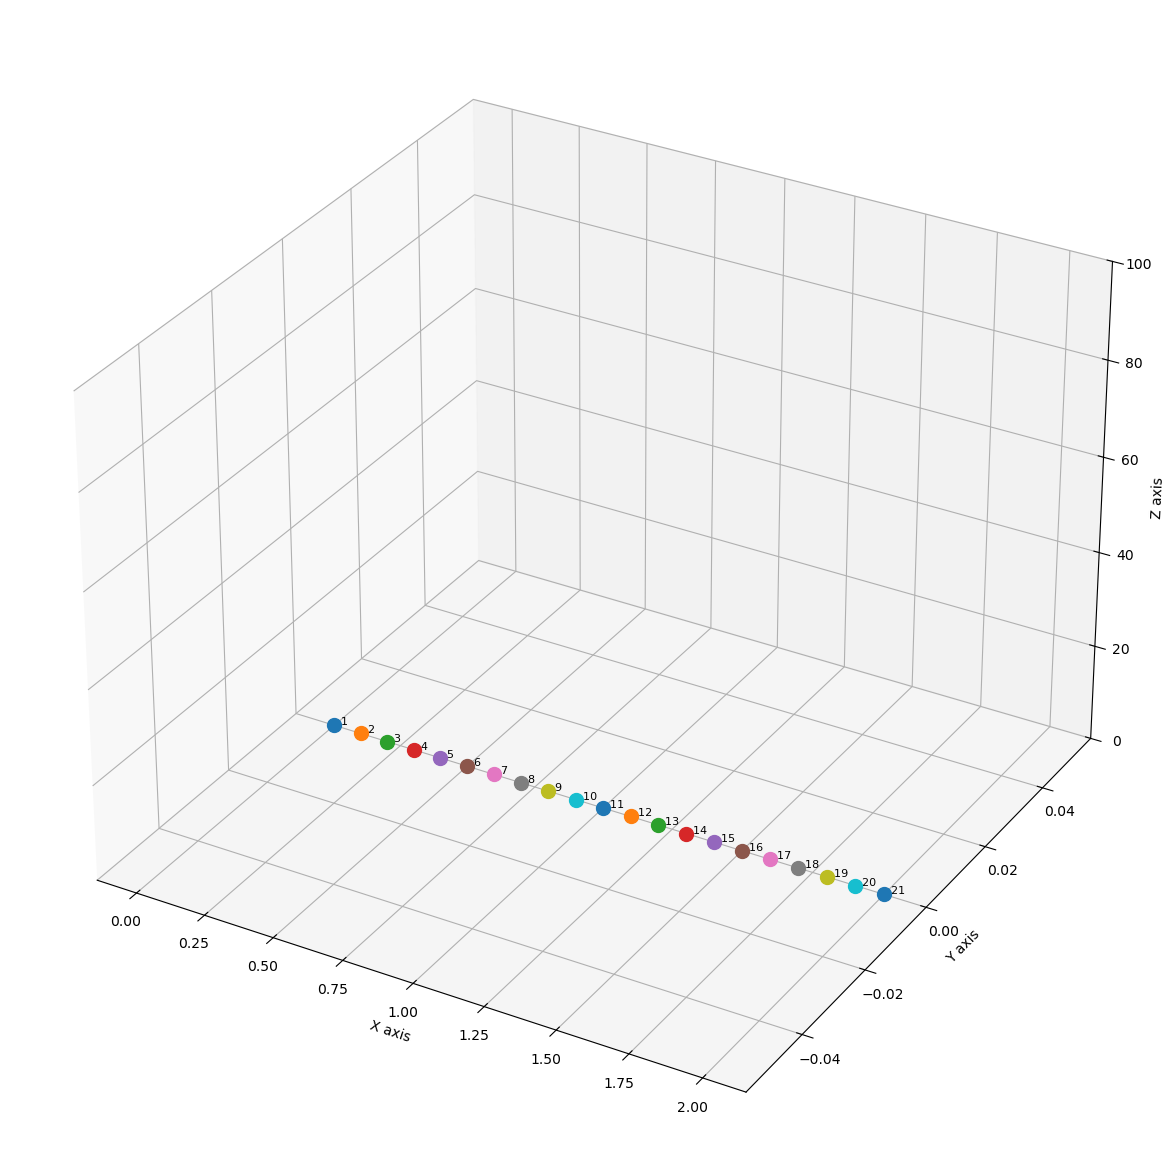

In [2]:
# Create nodes using a loop
nodes = []
for i in range(21):
    nodes.append(n.nodes(i * 0.1, 0, 0))

# Unpack nodes to individual variables for compatibility with existing code
n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11, n12, n13, n14, n15, n16, n17, n18, n19, n20, n21 = nodes[:21]

n.plot_nodes(nodes)

In [3]:

E=210e9
rho=7850
b=0.05
h=0.1
A=b*h
Iy=b*h**3/12
Iz=h*b**3/12
It = (b*h**3) 
L = 0.1
Ip = ((h**2 + b**2) / 12 )* (L * h * b * rho)
k = 5/6 
G= E/(2*(1+0.3))


ep_K = [E, G, A, Iy, Iz, It, k]
ep_M = [rho, A, Iy, Iz, Ip]



In [4]:
elements = [(n1, n2, ep_K, ep_M), (n2, n3, ep_K, ep_M), (n3, n4, ep_K, ep_M), (n4, n5, ep_K, ep_M),
            (n5, n6, ep_K, ep_M), (n6, n7, ep_K, ep_M), (n7, n8, ep_K, ep_M), (n8, n9, ep_K, ep_M),
            (n9, n10, ep_K, ep_M), (n10, n11, ep_K, ep_M), (n11, n12, ep_K, ep_M), (n12, n13, ep_K, ep_M),
            (n13, n14, ep_K, ep_M), (n14, n15, ep_K, ep_M), (n15, n16, ep_K, ep_M), (n16, n17, ep_K, ep_M), (n17, n18, ep_K, ep_M),
            (n18, n19, ep_K, ep_M), (n19, n20, ep_K, ep_M), (n20, n21, ep_K, ep_M)]    

N = 21
DOF_per_node = 6

# K_global matrix
K_global = np.zeros((N*DOF_per_node, N*DOF_per_node))
M_global = np.zeros((N*DOF_per_node, N*DOF_per_node))

K_locs = []
M_locs = []
for i in range(len(elements)):
    _,_,M_loc, K_loc = e.elements(*elements[i])  
    K_locs.append(K_loc)
    M_locs.append(M_loc)

for i, K_loc in enumerate(K_locs):
    # Start DOF for first node of element
    start_dof = i * DOF_per_node
    # End DOF covers both nodes of the element
    end_dof = start_dof + 2*DOF_per_node
    
    # Add element stiffness into the global matrix
    K_global[start_dof:end_dof, start_dof:end_dof] += K_loc
    M_global[start_dof:end_dof, start_dof:end_dof] += M_loc


In [5]:
# Remove all rotations around the x-axis (torsional DOFs) for all nodes
remove_DOFs = np.sort(list(range(3, 126, 4)) + list(range(0, 3)) + list(range(N*DOF_per_node - 6, N*DOF_per_node-3)))
keep_DOFS = np.array([i for i in range(N*DOF_per_node) if i not in remove_DOFs])
print("Indices to remove:", remove_DOFs)
print("keep_DOFS:", keep_DOFS)


Indices to remove: [  0   1   2   3   7  11  15  19  23  27  31  35  39  43  47  51  55  59
  63  67  71  75  79  83  87  91  95  99 103 107 111 115 119 120 121 122
 123]
keep_DOFS: [  4   5   6   8   9  10  12  13  14  16  17  18  20  21  22  24  25  26
  28  29  30  32  33  34  36  37  38  40  41  42  44  45  46  48  49  50
  52  53  54  56  57  58  60  61  62  64  65  66  68  69  70  72  73  74
  76  77  78  80  81  82  84  85  86  88  89  90  92  93  94  96  97  98
 100 101 102 104 105 106 108 109 110 112 113 114 116 117 118 124 125]


In [6]:
K_global_reduced = K_global[np.ix_(keep_DOFS, keep_DOFS)]
M_global_reduced = M_global[np.ix_(keep_DOFS, keep_DOFS)]


In [7]:
# Obtain the eigenvalues and eigenvectors of the reduced system
eigvals_global, eigvecs_global = np.linalg.eig(np.linalg.inv(M_global_reduced) @ K_global_reduced)
frequencies_global = np.sort(np.sqrt(eigvals_global))
sorted_indices = np.argsort(np.sqrt(eigvals_global))
eigvecs_global = eigvecs_global[:, sorted_indices]


print("Natural frequencies (rad/s):", frequencies_global[0:4])
print("Natural frequencies (Hz):", frequencies_global[0:4]/(2*np.pi))

Natural frequencies (rad/s): [ 290.32152385 1150.35322683 2548.68928844 4437.30376433]
Natural frequencies (Hz): [ 46.20610561 183.08440235 405.63649866 706.21882809]


In [8]:
eigvecs_full = e.expand_eigenvectors(eigvecs_global, keep_DOFS, N*DOF_per_node)
print("Expanded eigenvectors shape:", eigvecs_full.shape)


Expanded eigenvectors shape: (126, 89)


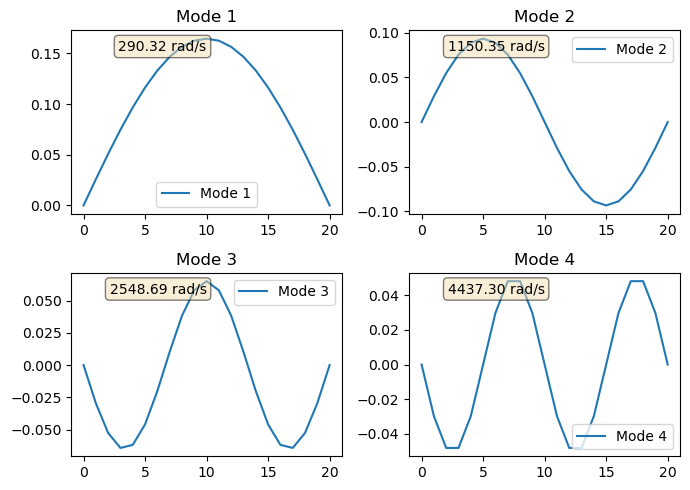

In [9]:
# plot modes in the y-direction
fig, axs = plt.subplots(2, 2, figsize=(7, 5))
axs[0, 0].plot(eigvecs_full[2::6, 0], label='Mode 1')
axs[0, 0].set_title('Mode 1')
axs[0, 0].legend()

axs[0, 1].plot(eigvecs_full[2::6, 1], label='Mode 2')
axs[0, 1].set_title('Mode 2')
axs[0, 1].legend()

axs[1, 0].plot(eigvecs_full[2::6, 2], label='Mode 3')
axs[1, 0].set_title('Mode 3')
axs[1, 0].legend()

axs[1, 1].plot(eigvecs_full[2::6, 3], label='Mode 4')
axs[1, 1].set_title('Mode 4')
axs[1, 1].legend()

plt.tight_layout()
plt.tight_layout()
for i in range(4):
    row, col = i // 2, i % 2
    freq_rad_s = frequencies_global[i]
    axs[row, col].text(0.5, 0.95, f'{freq_rad_s:.2f} rad/s', 
                       transform=axs[row, col].transAxes, 
                       verticalalignment='top', horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()